## importing the libraries

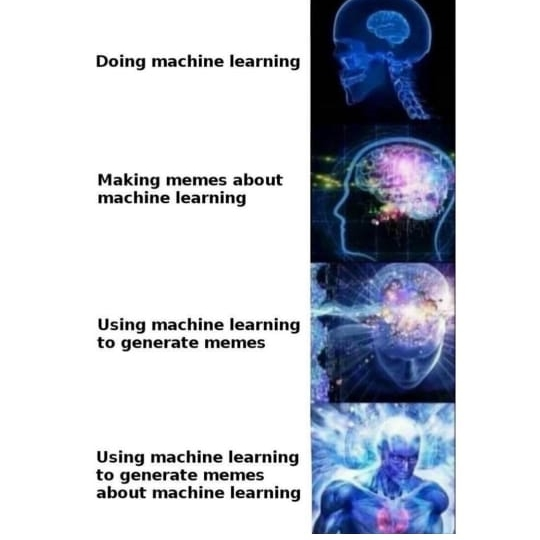

In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from sklearn.compose import ColumnTransformer # used to transform column
from sklearn.pipeline import Pipeline # used to combine several transforms
from sklearn.impute import SimpleImputer # used for replace missing value
from sklearn.preprocessing import StandardScaler, OneHotEncoder # convert numeric data to one-scale
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # fits  decision trees on parameter combinations
from sklearn.model_selection import train_test_split, GridSearchCV # method to  splits, and GridSearch for parameter tuning
from xgboost.sklearn import XGBClassifier
import pandas as pd #  for dataframe operations
import numpy as np #  for array/math operations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score # evaluation metric
from pprint import pprint #  print in a readable format
from skopt import BayesSearchCV # bayesian optimization from scikit-optimize
from skopt.space import Real, Categorical, Integer # supporting search space dimensions for integer, categorical, and float data
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import PredefinedSplit

In [ ]:
#load the  data
df = pd.read_csv('train.csv')
df1=pd.read_csv('test.csv')
df

,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,...,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3,id
0,0,3,2,14,18,2,2.0,14,12,372.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2583
1,1,14,1,3,10,2,NaN,8,8,63.0,...,8.0,8.0,7.0,8.0,NaN,NaN,NaN,NaN,NaN,6830
2,1,14,1,13,10,8,8.0,10,10,331.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4840
3,1,38,2,9,20,18,13.0,6,7,200.0,...,9.0,8.0,8.0,6.0,NaN,NaN,NaN,NaN,NaN,5508
4,1,24,2,14,20,6,6.0,20,17,357.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5904,0,1,2,9,20,2,2.0,18,1,214.0,...,12.0,12.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN,3390
5905,1,24,2,9,20,19,15.0,5,6,199.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4130
5906,0,13,2,11,21,5,5.0,3,18,290.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1178
5907,1,10,2,7,16,6,14.0,9,10,151.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5016


<AxesSubplot:>

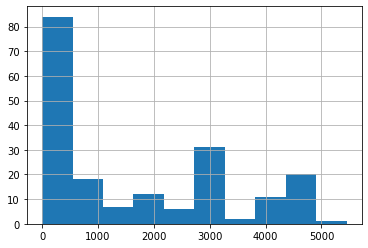

In [ ]:
df.isnull().sum().hist() #displaying the null values

# preparing the data for the pipeline

In [ ]:
x = df.drop('match', axis=1) #  removing target attribute
features_numeric = list(x.select_dtypes(include=['float64'])) #  list numeric attributes
features_categorical = list(x.select_dtypes(include=['object'])) # list  categorical attributes
y = df['match'] # slice  target attributes from training split

In [ ]:
print(features_categorical) # printing the list of categorical features


['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


# start  define the pipeline

In [ ]:
np.random.seed(0) # setting the random seed

#  impute missing numeric values
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')), # impute missing values with the feature median
        ('scaler', StandardScaler())] #  convert feature to one scale
)

#  impute missing categorical values
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), #  replace missing values with  'missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore')) #  encodes unknown categories
    ]
)

# combines into one transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), #  numeric transformer to numeric features
        ('cat', transformer_categorical, features_categorical) # categorical transformer to numeric features
    ]
)

# complete pipeline for a random forest classifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), #  complete preprocessing transformer
        #  random forest classifier
        ('my_classifier',
           RandomForestClassifier(),
        )
    ]
)


# parameter grid used for GridSearch
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'],
    'my_classifier__n_estimators': [20, 30, 40],
    'my_classifier__max_depth':[10, 20, 30]
}
X2, X_val, y2, y_val = train_test_split(
    x, y, train_size = 0.8, stratify = y, random_state = 2022)

# Create a list where train data indices are -1 and validation data indices are 0
# X2 (new training set)
split_index = [-1 if x in X2.index else 0 for x in x.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

grid_search = GridSearchCV(
    full_pipline, param_grid, cv=pds, verbose=1, n_jobs=2,
    scoring='roc_auc')

# here we still use X; but the grid search model
# will use our predefined split internally to determine
# which sample belongs to the validation set
grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_))
print('best score {}'.format(grid_search.best_params_))

Fitting 1 folds for each of 9 candidates, totalling 9 fits
best score 0.8259731460950973
best score {'my_classifier__max_depth': 20, 'my_classifier__n_estimators': 40, 'preprocessor__num__imputer__strategy': 'mean'}


In [ ]:
submission = pd.DataFrame() #  recording submission scores
submission['id'] = df1['id'] # Series of samples for which predictions
submission['match'] = grid_search.predict_proba(df1)[:,1] # use grid search to predict  for each sample in test split
submission.to_csv('sample_submission_walkthrough.csv', index=False) # generate submission csv
submission # printing submission results data

,id,match
0,934,0.083617
1,6539,0.386598
2,6757,0.200402
3,2275,0.122789
4,1052,0.141363
...,...,...
2464,7982,0.239362
2465,7299,0.431407
2466,1818,0.094404
2467,937,0.056496


# second trail is svm

In [ ]:
# pipeline for SVC model
SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), #  using same pipeline
        ('my_svc', SVC(class_weight='balanced')) # balanced class weights
    ]
)



bayes_search = BayesSearchCV(
    SVC_pipline, # Using SVC pipeline for Bayesian Optimization
    # bayes search parameter 'grid'
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'), # s regularization parameter C
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # sampling range for kernel coefficient gamma
        'my_svc__degree': Integer(1,8), #  range for degree of  polynomial
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']), # different kernel types
    },
    n_iter=3,
    random_state=0,
    verbose=1,
    cv=pds,
)

bayes_search.fit(x, y) # run bayes search  3 iterations

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


BayesSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['positin1',
                                                                           'pid',
                                                                           'int_corr',
                                                                           'age_o',
       

In [ ]:
print('best score {}'.format(bayes_search.best_score_)) # best  score from bayesian optimization
print('best score {}'.format(bayes_search.best_params_)) # parameter set on model with best performance

best score 0.8248730964467005
best score OrderedDict([('my_svc__C', 0.0012602593949011189), ('my_svc__degree', 8), ('my_svc__gamma', 2.285959941576884), ('my_svc__kernel', 'poly')])


Trial 2 observations and thoughts The SVC model outperforms the random forest classifier, but it employs a different optimization strategy (Bayes instead of Grid). Because the performance is already good , we should concentrate our efforts in the DS tuning life cycle on experimenting with different model architectures and tuning hyperparameters to improve performance and leaderboard score

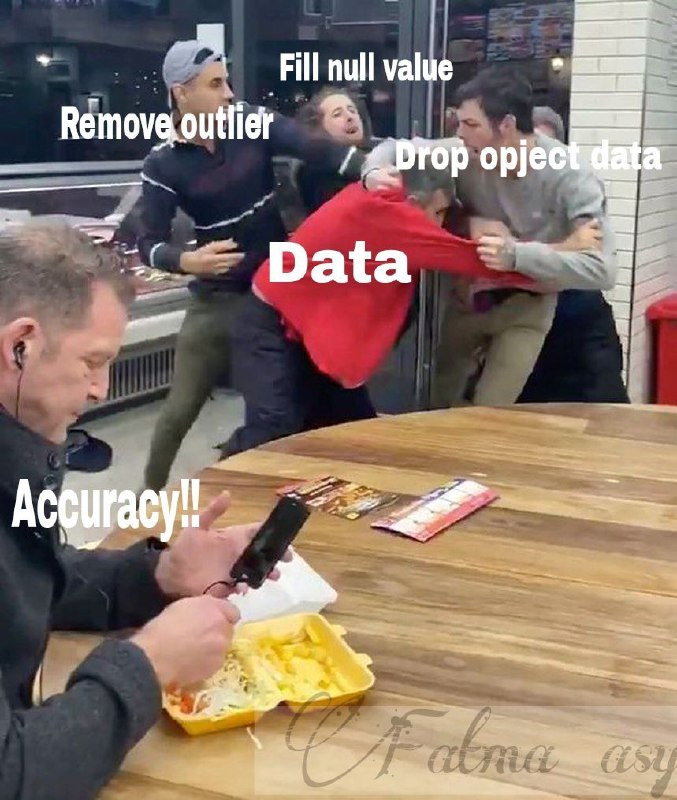

# trail 3 random forest

In [ ]:
rafo_pipe = Pipeline(
 steps=[
 ('preprocessor', preprocessor), # same preprocessing pipeline
 ('rf', RandomForestClassifier(random_state=0)) # random forest classifier with random seed set
 ]
)

rafo_par = {
 # most frequent is the mode
 'preprocessor__num__imputer__strategy': ['mean','median', 'most_frequent'],
 # wider range
 'rf__n_estimators': [10,20,30,40,50,100],
 'rf__max_depth':[5,10,20,30,50],
 # different criteria
 'rf__criterion':['gini','entropy'],
 # varying the number of features
 'rf__max_features':['auto','sqrt','log2'],
 #  handle imbalanced target
 'rf__class_weight':['balanced','balanced_subsample']
}
radam = RandomizedSearchCV(
    rafo_pipe,
    rafo_par,
    cv=pds,
    n_iter=20,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
radam.fit(x, y)
print('best score {}'.format(radam.best_score_))
print('best params {}'.format(radam.best_params_))
  #saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = radam.predict_proba(df1)[:,1]
  # generate csv
submission.to_csv('sample_submission_walkthrough.csv', index=False)




Fitting 1 folds for each of 20 candidates, totalling 20 fits
best score 0.8478124743368646
best params {'rf__n_estimators': 100, 'rf__max_features': 'auto', 'rf__max_depth': 10, 'rf__criterion': 'gini', 'rf__class_weight': 'balanced', 'preprocessor__num__imputer__strategy': 'most_frequent'}


Observations and thoughts for trial 3-1: I expected the best configuration to include more estimators, but because only 20 iterations were conducted on a large parameter space,  estimators may not have been present in one of the configurations examined

# random forest with bayesian

In [ ]:
rafo_pipe = Pipeline(
 steps=[
 ('preprocessor', preprocessor), # same preprocessing pipeline
 ('rf', RandomForestClassifier(random_state=0)) # random forest classifier with random seed set
 ]
)
rafo_bayes = {

 'preprocessor__num__imputer__strategy': Categorical(['mean','median', 'most_frequent']),
 'rf__n_estimators': Integer(10,500),
 'rf__max_depth': Integer(5,50),
 'rf__criterion': Categorical(['gini','entropy']),
 'rf__max_features': Categorical(['auto','sqrt','log2']),
 'rf__class_weight': Categorical(['balanced','balanced_subsample'])
}
bayes = BayesSearchCV(
    rafo_pipe,
    rafo_bayes,
    cv=pds,
    n_iter=20,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

Observations and thoughts for trial 3-2: It's interesting that the numbers for number of estimators and max depth neared the minimum and maximum values in only 20 trials. The development score is also higher than random search, owing to the fact that Bayes search is similar to informed random search in that it keeps note of excellent and bad values. When utilising grid search to filter down the optimum parameters in future trials


# random forest with grid search

In [ ]:
rafo_pipe = Pipeline(
 steps=[
 ('preprocessor', preprocessor), # same preprocessing pipeline
 ('rf', RandomForestClassifier(random_state=0)) # random forest classifier with random seed set
 ]
)
rafo_grid = {
 'preprocessor__num__imputer__strategy': ['mean','median', 'most_frequent'],
 'rf__n_estimators': [10,20,30,40,50,100],
 'rf__max_depth':[5,10,20,30,50],
 'rf__class_weight':['balanced','balanced_subsample']
}
grid = GridSearchCV(
    rafo_pipe,
    rafo_grid,
    cv=pds,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
grid.fit(x, y)
print('best score {}'.format(grid.best_score_))
print('best params {}'.format(grid.best_params_))
  # prepare submission:
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = grid.predict_proba(df1)[:,1]
  # generate csv with naming convention based on function name
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 180 candidates, totalling 180 fits
best score 0.8478124743368646
best params {'preprocessor__num__imputer__strategy': 'most_frequent', 'rf__class_weight': 'balanced', 'rf__max_depth': 10, 'rf__n_estimators': 100}


 for the 3-3: The performance is lower than that of the Bayes search, and the training time is much longer. Grid search is also inflexible, with no option to accept values outside the stated parameter ranges, which is likely why Bayes search outperformed grid search.

Random search is substantially faster than grid search, and Bayes search is likewise much faster. Furthermore, despite taking less time, random search produces results that are comparable to both other searches. This makes it easier to narrow down the sorts of parameter values that seem to work before using grid search or Bayes search to get the optimal set of parameters.

# trail 4 logistic regression

In [ ]:
# using balanced class weights
lore_par= {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'logreg__penalty': ['l2'],
 'logreg__C':[0.1,0.5,1,1.5],
 'logreg__solver':['sag', 'saga'],
 'logreg__max_iter':[100,300,600],
 'logreg__class_weight':['balanced']
}

lore_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('logreg', LogisticRegression())
 ]
)
radam = RandomizedSearchCV(
    lore_pipe,
    lore_par,
    cv=pds,
    n_iter=30,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
radam.fit(x, y)
print('best score {}'.format(radam.best_score_))
print('best params {}'.format(radam.best_params_))
  #saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = radam.predict_proba(df1)[:,1]
  # generate csv
submission.to_csv('sample_submission_walkthrough.csv', index=False)


Fitting 1 folds for each of 30 candidates, totalling 30 fits
best score 0.8611881005173688
best params {'preprocessor__num__imputer__strategy': 'most_frequent', 'logreg__solver': 'sag', 'logreg__penalty': 'l2', 'logreg__max_iter': 300, 'logreg__class_weight': 'balanced', 'logreg__C': 0.1}


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Trial 4:Logistic regression performs effectively across a wide parameter grid.It's worth noting that the lesser values of max iter had achieved their maximum number of iterations, thus greater numbers were added in subsequent tries.

# trail 5 KNN

In [ ]:
knn_par = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'knn__n_neighbors': [70,100,120,150],
 'knn__weights':['uniform', 'distance'],
 'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
 'knn__p':[1,2]
}

knn_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('knn', KNeighborsClassifier())
 ]
)
radam = RandomizedSearchCV(
    knn_pipe,
    knn_par,
    cv=pds,
    n_iter=10,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
radam.fit(x, y)
print('best score {}'.format(radam.best_score_))
print('best params {}'.format(radam.best_params_))
  #saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = radam.predict_proba(df1)[:,1]
  # generate csv
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 10 candidates, totalling 10 fits
best score 0.8054683008951302
best params {'preprocessor__num__imputer__strategy': 'most_frequent', 'knn__weights': 'distance', 'knn__p': 2, 'knn__n_neighbors': 150, 'knn__algorithm': 'brute'}


Observations and thoughts for trial 5: KNN does not outperform the other choices across a wide parameter grid. It does, however, function admirably and is easy to learn. With 150 neighbours, the initial effort did the best, thus future tries tried higher values until performance plateaued.  the score on the leaderpoard may be worse

# trail 6  desision tree

In [ ]:

dete_par = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'dt__criterion': ['gini','entropy'],
 'dt__splitter': ['best','random'],
 'dt__max_depth': [5,10,15,20],
 'dt__min_samples_leaf': [1,2,3,5,10],
 'dt__max_features': ['auto','sqrt','log2'],
 'dt__class_weight': ['None','balanced']
}
# pipeline for  decision tree classifier
dete_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('dt', DecisionTreeClassifier(random_state=0)) # random seed
 ]
)
radam = RandomizedSearchCV(
    dete_pipe,
    dete_par,
    cv=pds,
    n_iter=50,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
radam.fit(x, y)
print('best score {}'.format(radam.best_score_))
print('best params {}'.format(radam.best_params_))
  #saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = radam.predict_proba(df1)[:,1]
  # generate csv
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 50 candidates, totalling 50 fits


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan 0.60614273        nan
 0.54845457        nan        nan        nan 0.65290353 0.67923647
        nan 0.64583847        nan 0.69209883        nan 0.66645366
        nan        nan        nan        nan        nan 0.65700963
 0.64346206        nan 0.62348074        nan 0.66856831 0.68786185
 0.65283424 0.68786185 0.62205387        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 0.61073386 0.67523815 0.56225107 0.67917745        nan
        nan        nan]
  warnings.warn(


best score 0.6920988338671266
best params {'preprocessor__num__imputer__strategy': 'mean', 'dt__splitter': 'best', 'dt__min_samples_leaf': 1, 'dt__max_features': 'auto', 'dt__max_depth': 5, 'dt__criterion': 'entropy', 'dt__class_weight': 'balanced'}


 for trial 6: Despite searching a relatively broad parameter grid over 50 iterations, the performance oughtof a single decision tree isn't particularly excellent. This could be because the model was overfit to the training data and didn't generalise to the validation splits . The ensemble models appear to overcome this issue, as they perform substantially better

# trail 7 svm with bayes search

In [ ]:
svc_par = {
  'svc__C': Real(1e-6, 1e+6, prior='log-uniform'),
  'svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # sampling range for kernel coefficient gamma
  'svc__degree': Integer(1,8), #  range for degree of polynomial classifiers
  'svc__kernel': Categorical(['linear', 'poly', 'rbf']), # different kernel types
}
# pipeline for support vector classifier
svc_pipe = Pipeline(
    steps=[
     ('preprocessor', preprocessor),
     #  with balanced class weights
     ('svc', SVC(class_weight='balanced', random_state=0, probability=True))
    ]
)
bayes= BayesSearchCV(
    svc_pipe,
    svc_par,
    cv=pds,

    n_iter=5,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
best score 0.8170680381046236
best params OrderedDict([('svc__C', 2.8278448208704203e-05), ('svc__degree', 6), ('svc__gamma', 2.663251065262773e-06), ('svc__kernel', 'linear')])


 for trial 7: I'm not sure why, but this didn't seem to converge until a finite number of iterations was specified, even if only one iteration was specified.

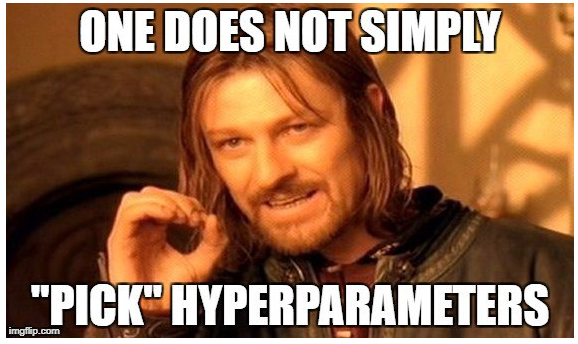

# trail 8 xgboost with random search

In [ ]:
#  varying the number of estimators and max tree depth
xgb_par = {
 'preprocessor__num__imputer__strategy': ['mean','median','most_frequent'],
 'xgb__n_estimators': [100,200,500],
 'xgb__max_depth':[5,7,10,15],
 'xgb__subsample':[0.6,0.8,1],
 'xgb__colsample_bytree':[0.5,1],
}
# pipeline for  an XGBoost classifier
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
radam = RandomizedSearchCV(
    xgb_pipe,
    xgb_par,
    cv=pds,
    n_iter=10,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
radam.fit(x, y)
print('best score {}'.format(radam.best_score_))
print('best params {}'.format(radam.best_params_))
  #saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = radam.predict_proba(df1)[:,1]
  # generate csv
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.8833969779091729
best params {'xgb__subsample': 1, 'xgb__n_estimators': 200, 'xgb__max_depth': 15, 'xgb__colsample_bytree': 1, 'preprocessor__num__imputer__strategy': 'mean'}


Trial 8: XGBoost is a potent model in applied machine learning, and it's easy to understand why in this case. Three tries at random search over multiple parameter grids yielded the results.

# trail 9 random forest with grid search

In [ ]:
rafo_params_grid = {
 'preprocessor__num__imputer__strategy': ['mean'],
 'rf__n_estimators': [1000,1500,2000],
 'rf__max_depth':[5,6,7,8],
 'rf__criterion':['entropy'],
 'rf__max_features':['auto'],
 'rf__class_weight':['balanced_subsample']
}
rafo_pipeline = Pipeline(
 steps=[
 ('preprocessor', preprocessor), # same preprocessing pipeline
 ('rf', RandomForestClassifier(random_state=0)) # random forest classifier with random seed set
 ])
grid = GridSearchCV(
    rafo_pipeline,
    rafo_params_grid,
    cv=pds,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
grid.fit(x, y)
print('best score {}'.format(grid.best_score_))
print('best params {}'.format(grid.best_params_))
  # prepare submission:
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = grid.predict_proba(df1)[:,1]
  # generate csv with naming convention based on function name
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
best score 0.848397593824423
best params {'preprocessor__num__imputer__strategy': 'mean', 'rf__class_weight': 'balanced_subsample', 'rf__criterion': 'entropy', 'rf__max_depth': 8, 'rf__max_features': 'auto', 'rf__n_estimators': 1500}


Trial 9: resulted in a slight improvement in performance., the logistic regression score from random search was still worse. It should be noted that a few attempts were made here, with certain aspects to save training time while examining various parameters extensively.

# trail 10 logestic regression with grid search

In [ ]:
# using the best parameters from the random search
lore_params = {
 'preprocessor__num__imputer__strategy': ['mean','median'],
 'logreg__penalty': ['l2'],
 'logreg__C':[0.1,0.5,1,1.5],
 'logreg__solver':['sag', 'saga'],
 'logreg__max_iter':[100,300,600]
}
lore_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('logreg', LogisticRegression())
 ]
)
grid = GridSearchCV(
    lore_pipe,
    lore_params,
    cv=pds,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
grid.fit(x, y)
print('best score {}'.format(grid.best_score_))
print('best params {}'.format(grid.best_params_))
  # prepare submission:
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = grid.predict_proba(df1)[:,1]
  # generate csv with naming convention based on function name
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 48 candidates, totalling 48 fits
best score 0.859643179765131
best params {'logreg__C': 0.1, 'logreg__max_iter': 600, 'logreg__penalty': 'l2', 'logreg__solver': 'sag', 'preprocessor__num__imputer__strategy': 'mean'}


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Trial 10: This is similar to the results received by random search, and it does not approach the xgboost score got through random search, so I will concentrate on xgboost in order to enhance my leaderboard score.

# trail 11 xgboost with grid search

In [ ]:
xgb_par = {
 'preprocessor__num__imputer__strategy': ['mean'],
 'xgb__n_estimators': [100,500],
 'xgb__max_depth':[3,5,7],
 'xgb__subsample':[0.6,0.8,1],
 'xgb__colsample_bytree':[0.5,1]
}
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
grid = GridSearchCV(
    xgb_pipe,
    xgb_par,
    cv=pds,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
grid.fit(x, y)
print('best score {}'.format(grid.best_score_))
print('best params {}'.format(grid.best_params_))
  # prepare submission:
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = grid.predict_proba(df1)[:,1]
  # generate csv with naming convention based on function name
submission.to_csv('sample_submission_walkthrough.csv', index=False)


Fitting 1 folds for each of 36 candidates, totalling 36 fits


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:03:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.882262667323643
best params {'preprocessor__num__imputer__strategy': 'mean', 'xgb__colsample_bytree': 0.5, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 1}


 for trial 11: While the validation score was slightly higher this time, . I believe there is still space for improvement, since many others on the leaderboard are outperforming me, so I'll attempt Bayes search to see if it helps. , which is costly when compared to a random search

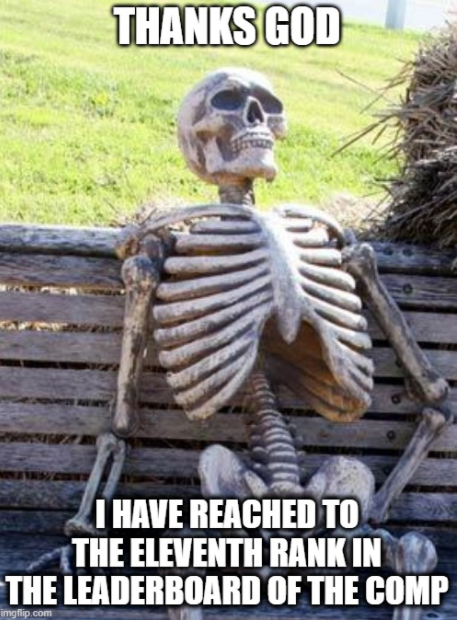

# trail 12 xgboost with bayes search

In [ ]:
# starting with only a few iterations and will increase if training time is acceptable
xgb_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']),
 'xgb__n_estimators': Integer(100,1000),
 'xgb__max_depth': Integer(3,10),
 'xgb__subsample':Real(0.6,1,prior='log-uniform'),
 'xgb__colsample_bytree':Real(0.5,1,prior='log-uniform'),
 'xgb__learning_rate':Real(0.01,0.3,prior='log-uniform')
}
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
bayes = BayesSearchCV(
    xgb_pipe,
    xgb_bayes,
    cv=pds,
    n_iter=10,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits


C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:04:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.8857887821302456
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.5338751785986166), ('xgb__learning_rate', 0.09483096534873453), ('xgb__max_depth', 3), ('xgb__n_estimators', 402), ('xgb__subsample', 0.7962337608180516)])


In [ ]:
xgb_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']),
 'xgb__n_estimators': Integer(100,1000),
 'xgb__max_depth': Integer(3,10),
 'xgb__subsample':Real(0.6,1,prior='log-uniform'),
 'xgb__colsample_bytree':Real(0.5,1,prior='log-uniform'),
 'xgb__learning_rate':Real(0.01,0.3,prior='log-uniform')
}
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
bayes = BayesSearchCV(
    xgb_pipe,
    xgb_bayes,
    cv=pds,
    n_iter=20,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.8865638088199064
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 1.0), ('xgb__learning_rate', 0.04623833207780869), ('xgb__max_depth', 6), ('xgb__n_estimators', 153), ('xgb__subsample', 0.7638575598572046)])


In [ ]:
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
xgb_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']),
 'xgb__n_estimators': Integer(100,1000),
 'xgb__max_depth': Integer(3,10),
 'xgb__subsample':Real(0.6,1,prior='log-uniform'),
 'xgb__colsample_bytree':Real(0.5,1,prior='log-uniform'),
 'xgb__learning_rate':Real(0.01,0.3,prior='log-uniform')
}
bayes = BayesSearchCV(
    xgb_pipe,
    xgb_bayes,
    cv=pds,
    n_iter=45,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:15:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.889489406257699
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.8841566171036194), ('xgb__learning_rate', 0.027604949866320543), ('xgb__max_depth', 5), ('xgb__n_estimators', 589), ('xgb__subsample', 0.6)])


In [ ]:
xgb_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']),
 'xgb__n_estimators': Integer(100,1000),
 'xgb__max_depth': Integer(3,10),
 'xgb__subsample':Real(0.6,1,prior='log-uniform'),
 'xgb__colsample_bytree':Real(0.5,1,prior='log-uniform'),
 'xgb__learning_rate':Real(0.01,0.3,prior='log-uniform')
}
xgb_pipe = Pipeline(
 steps=[
  ('preprocessor', preprocessor),
  ('xgb', XGBClassifier(objective='binary:logistic', seed=0)) # set random seed
 ]
)
bayes = BayesSearchCV(
    xgb_pipe,
    xgb_bayes,
    cv=pds,
    n_iter=50,
    verbose=3,
    n_jobs=2,
    scoring='roc_auc'
  )
bayes.fit(x, y)
print('best score {}'.format(bayes.best_score_))
print('best params {}'.format(bayes.best_params_))
  # saving submission
submission = pd.DataFrame()
submission['id'] = df1['id']
submission['match'] = bayes.predict_proba(df1)[:,1]
submission.to_csv('sample_submission_walkthrough.csv', index=False)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fi

C:\Users\Lab 3\Documents\Newfolder\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
best score 0.8892225096493389
best params OrderedDict([('preprocessor__num__imputer__strategy', 'mean'), ('xgb__colsample_bytree', 0.5434201091343233), ('xgb__learning_rate', 0.03759870015592096), ('xgb__max_depth', 5), ('xgb__n_estimators', 674), ('xgb__subsample', 0.9529461475496637)])


Finally, some thoughts: Bayes search takes about the same amount of time as grid search after 10 iterations, but it can search a significantly larger parameter space. Furthermore, increasing the number of iterations boosted my score. However, I believe that the performance does not necessarily improve with the number of iterations because the search for the parameter range can become stuck in local maxima. Nonetheless, this technique (XGBoost + Bayes) assisted me in achieving my highest score on the leaderboard and significantly enhanced the model's performance. The model does not appear to overfit to the validation/development split when tuned using the data science lifecycle. As a result, I believe that this final procedure satisfies the assignment's requirements.

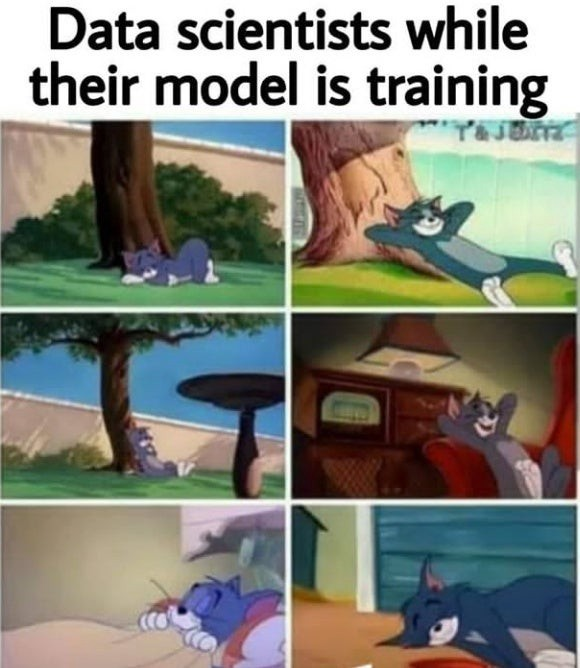

# questions

### Why a simple linear regression model (without any activation function) is not good for classification task, compared to Perceptron/Logistic regression?
The majority of the time, data is not linearly separable. Simple linear regression is only good for separating two-dimensional data, and the decision boundary is just a line. Higher-dimensional data, on the other hand, necessitates a more complicated classifier, such as SVM.
A- Linear Regression is in charge of resolving regression issues. A set of distinct variables is used to identify regression in terms of a continuous dependent variable. Logistic regression, on the other hand, is in charge of classifying data into one of several categories.
The following are some additional considerations:
Logistic regression was introduced because regression may give probabilities that were less than 0 or even more than 1.
b- The outcome (dependent variable) in linear regression is continuous. It can take on any of an unlimited number of different forms. In logistic regression, on the other hand, the result (dependent variable) has a finite number of possible values. When your response variable is continuous, linear regression is performed. For example, weight, height, number of hours worked, and so on; whereas, when the response variable is categorical, logistic regression is utilised. Yes/no, true/false, red/green/blue, 1st/2nd/3rd/4th, and so on.

### What's a decision tree and how it is different to a logistic regression model?

Based on the values of specific attributes, decision trees divide data into smaller groupings. This procedure shrinks the entire dataset until all data points inside a subset of one of the leaf nodes have the same answer. The anticipated output in logistic regression is based on a function, and it works well with continuous data. Both classifiers are discriminative, which makes them similar.
A. Decision Trees (DTs) are a supervised learning method for classification and regression that is non-parametric. The goal is to learn simple decision rules from data attributes to develop a model that predicts the value of a target variable. A tree is an approximation to a piecewise constant.
Difference:Decision Trees divide the space into smaller and smaller sections, whereas Logistic Regression fits a single line to precisely divide the space into two. b) When a tree has a high number of nodes, understanding all of the splits that lead up to a particular prediction can take a lot of mental effort. A Logistic Regression model, on the other hand, is just a list of coefficients. c) When compared to Logical Regression, Decision Trees handle skewed classes better. d) Missing values are not handled by logistic regression; we must impute those values using the mean, mode, and median. Imputing missing values may not be a smart idea if there are a lot of them, because we are affecting the distribution of data by imputing mean everywhere.Missing values are dealt with using Decision Trees.

### What's the difference between grid search and random search?
Grid Search can be thought of as a thorough search for a model to choose from. In Grid Search, the data scientist creates a grid of hyperparameter values, trains a model, and scores it on the testing data for each combination. This method tries every possible combination of hyperparameter values, which can be inefficient.
This is the most basic approach of hyperparameter adjustment. A grid of hyperparameter values is defined. The tuning process iteratively searches this space for every possible combination of hyperparameter values, training a model for each one.
Because the number of models to train rises exponentially with the number of hyperparameters to train, grid search is rarely employed in practise.This is inefficient in terms of both processing power and time.

To train and score the model, Random Search creates a grid of hyperparameter values and selects random combinations from it. This allows you to specify the number of parameter combinations that will be tried. The number of search iterations is determined by the amount of time or resources available. For this, Scikit Learn provides the RandomizedSearchCV function.

### What's the difference between bayesian search and random search?
We don't supply an explicit list of possible values for each hyperparameter in random search; instead, we present a statistical distribution for each hyperparameter from which values are sampled. To perform a randomised search, we define a sample distribution for each hyperparameter. We can also regulate or limit the amount of hyperparameter combinations employed. Unlike grid search, which evaluates every conceivable combination, random search allows us to define a predetermined number of models to train and then stop the tuning method. The number of search iterations can also be determined by the amount of time or resources available.algorithm that chooses the next hyperparameter value candidates based on the results of the previous iteration.
Rather of scanning the hyperparameter space blindly (as in grid search and random search), this method recommends using intelligence to select the next set of hyperparameters that will increase model performance. This method is repeated iteratively until we reach an optimal result.


#  Problem Formulation

The goal of this challenge is to forecast if two people will'match' during a specific speed dating session. We're working with a profile of each individual in the session as input, and the result is a prediction of whether or not there will be a successful match (binary classification). Because we are predicting chance of a match rather than class labels, AUROC (or ROCAUC) is utilised as the evaluation metric on the predictions. Due to incomplete dating profiles, numerous values in the dataset are missing. As a result, new preprocessing procedures to impute/replace missing data, as well as categorical encoding to work with numeric features, will be required.Following preprocessing, various models will be compared to predict the likelihood of a successful match. The difficulties will be determining the best technique for substituting missing values and determining the best hyperparameters for each model. For hyperparameter optimization, three alternative search techniques will be employed (Grid Search, Random Search, and Bayesian Optimization). An ideal solution will effectively address these problems by creating a dataset-representative missing value replacement technique and optimising hyperparameters to make the most accurate predictions possible. Understanding the traits that contribute to successful pairings would be the impact of this perfect solution. Furthermore, this would provide an opportunity to make useful recommendations for future speed dating events.

# What is the experimental protocol used and how was it carried out?

The following is the experimental protocol or procedure: For starters, multiple methodologies for missing value replacement are used by data preparation measures for both numeric and categorical data. On the preprocessed dataset, a classifier is then utilised to produce predictions. Finally, multiple hyperparameter search techniques were used to tune/optimize hyperparameters (grid search for generating template submission, and bayes search on another classifier—worse performance). To streamline procedures, pipelines from the scikit-learn API were used to complete tasks in a sequential order. Furthermore, column transformers were used for preprocessing.